In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
sns.set_palette('muted')

## Contents
1. [Load & Visualize Time Series](#load_viz)
2. [Change Point Detection](#cpd)
3. [Autocorrelation Functions (ACF/PACF)](#acf_pacf)
4. [ARIMA Modeling](#arima_modeling), [ARIMA Forecasting](#arima_forecasting)
5. [Exogenous Variables](#exog)
6. [Modeling with Exogenous Variables](#exog_modeling), [Forecasting with Exogenous Variables](#exog_forecasting)

<a id='load_viz'></a>
## Load & Visualize Time Series

In [2]:
df_orig = pd.read_json('df.json', orient='split')
print(df_orig.info())
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981 entries, 0 to 2980
Data columns (total 16 columns):
date              2981 non-null datetime64[ns]
eth_open          1134 non-null float64
eth_high          1134 non-null float64
eth_low           1134 non-null float64
eth_close         1134 non-null float64
eth_volumefrom    1134 non-null float64
eth_volumeto      1134 non-null float64
btc               2981 non-null float64
xrp               1332 non-null float64
eos               442 non-null float64
ltc               1786 non-null float64
xlm               605 non-null float64
xmr               1324 non-null float64
vixcls            2981 non-null float64
twexb             2981 non-null float64
effr              2981 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 395.9 KB
None


,date,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr
0,2010-07-16,NaN,NaN,NaN,NaN,NaN,NaN,0.04951,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19
1,2010-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.08584,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19
2,2010-07-18,NaN,NaN,NaN,NaN,NaN,NaN,0.08080,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19


In [3]:
# set df for time series
df = df_orig[['date', 'eth_close']]
df.rename(columns={'eth_close':'eth'}, inplace=True)

# start at the beginning of ethereum
df = df[df.eth.isnull().sum():]
df.set_index('date', inplace=True)
df.head()

,eth
date,
2015-08-06,3.00
2015-08-07,1.20
2015-08-08,1.20
2015-08-09,1.20
2015-08-10,0.99


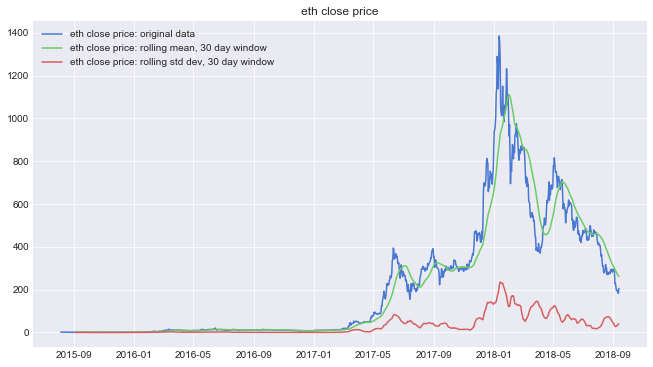

adf: -1.8088972361212996
pval: 0.37605349542421385
critical vals {'1%': -3.4362549432361504, '5%': -2.8641473395601595, '10%': -2.568158225793361}


In [4]:
plt.figure(figsize=(11,6))
plt.plot(
    df.index.values,
    df.eth,
    label='eth close price: original data'
)
plt.plot(
    df.index.values,
    df.eth.rolling(30).mean(),
    label='eth close price: rolling mean, 30 day window'
)
plt.plot(
    df.index.values,
    df.eth.rolling(30).std(),
    label='eth close price: rolling std dev, 30 day window'
)
plt.title('eth close price')
plt.legend(loc='upper left')
plt.show()

from statsmodels.tsa.stattools import adfuller
print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(df.eth)[0],
    adfuller(df.eth)[1],
    adfuller(df.eth)[4]))

**Interpretation:**
- Data displays trend
- Graph indicates presence of structural breaks
- Data does not show stationarity
- ADF test confirms data is not stationary

<a id='cpd'></a>
## Change Point Detection
- [Ruptures Library](https://github.com/deepcharles/ruptures) used for change point detection
- Pruned Exact Linear Time (PELT): penalized change point detection algorithm

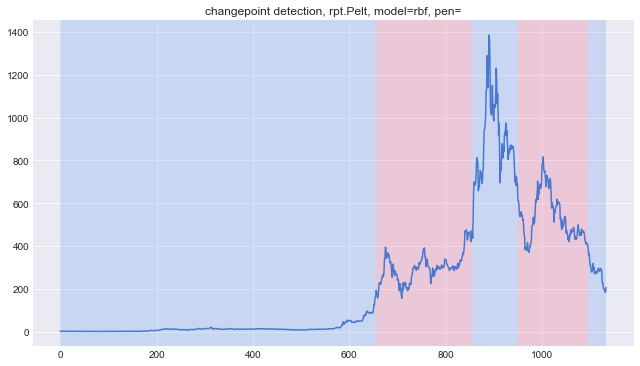

[655, 855, 950, 1095, 1134]
len: 5


In [5]:
import ruptures as rpt
cpts = rpt.Pelt(model='rbf').fit_predict(df, pen=20)

rpt.display(df, cpts, figsize=(9,5))
plt.title('changepoint detection, rpt.Pelt, model=rbf, pen=')
plt.show()
print(cpts)
print('len: {}'.format(len(cpts)))

In [6]:
# split df by changepoints
df_01 = df[:cpts[0]]
df_02 = df[cpts[0]:cpts[1]]
df_03 = df[cpts[1]:cpts[2]]
df_04 = df[cpts[2]:cpts[3]]
df_05 = df[cpts[3]:]

In [7]:
# a few attempts at stationarity
df_05['diff_1'] = df_05.eth - df_05.eth.shift(1)
df_05['diff_2'] = df_05.eth - df_05.eth.shift(2)
df_05['log'] = np.log(df_05.eth)
df_05['log_diff_1'] = np.log(df_05.eth).diff().dropna()
df_05['sqrt'] = np.sqrt(df_05.eth)

# drop nans from differencing
#df_05 = df_05[2:]

print('\ndiff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.diff_1[2:])[0],
    adfuller(df_05.diff_1[2:])[1],
    adfuller(df_05.diff_1[2:])[4]))

print('\ndiff_2\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.diff_2[2:])[0],
    adfuller(df_05.diff_2[2:])[1],
    adfuller(df_05.diff_2[2:])[4]))

print('\nlog\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.log[2:])[0],
    adfuller(df_05.log[2:])[1],
    adfuller(df_05.log[2:])[4]))

print('\nlog_diff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.log_diff_1[2:])[0],
    adfuller(df_05.log_diff_1[2:])[1],
    adfuller(df_05.log_diff_1[2:])[4]))

print('\nsqrt\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.sqrt[2:])[0],
    adfuller(df_05.sqrt[2:])[1],
    adfuller(df_05.sqrt[2:])[4]))


diff_1
adf=-6.510154885699868, npval=1.1055657285641474e-08
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}

diff_2
adf=-3.4245909084003934, npval=0.010148594477575414
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}

log
adf=-1.1181880973903484, npval=0.7077644717476341
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}

log_diff_1
adf=-6.127515314357007, npval=8.557942321507575e-08
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}

sqrt
adf=-1.2571260019594184, npval=0.6485520022410395
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}


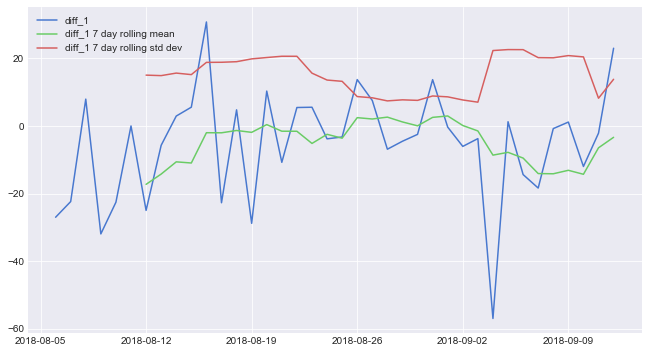


diff_1
adf=-6.510154885699868, npval=1.1055657285641474e-08
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}


In [8]:
window = 7

plt.figure(figsize=(11,6))
plt.plot(df_05.index.values,
         df_05.diff_1,
         label='diff_1')
plt.plot(df_05.index.values,
         df_05.diff_1.rolling(window).mean(),
         label='diff_1 {} day rolling mean'.format(window))
plt.plot(df_05.index.values,
         df_05.diff_1.rolling(window).std(),
         label='diff_1 {} day rolling std dev'.format(window))
plt.legend()
plt.show()

print('\ndiff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.diff_1[2:])[0],
    adfuller(df_05.diff_1[2:])[1],
    adfuller(df_05.diff_1[2:])[4]))

<a id='acf_pacf'></a>
## Autocorrelation Functions (ACF/PACF)

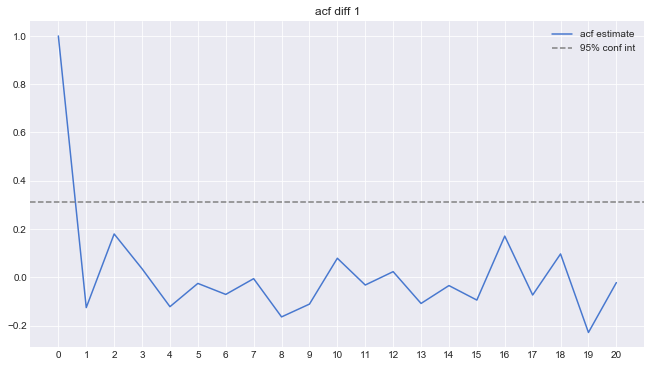

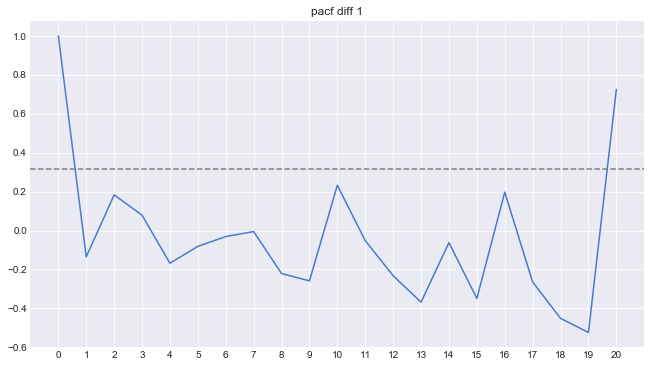

In [9]:
diff_1_acf = acf(df_05.diff_1[2:], nlags=20)
diff_1_pacf = pacf(df_05.diff_1[2:], nlags=20, method='ols')

plt.figure(figsize=(11,6))
plt.plot(diff_1_acf, label='acf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_05.diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('acf diff 1')
plt.legend()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(diff_1_pacf, label='pacf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_05.diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('pacf diff 1')
plt.show()

<a id='arima_modeling'></a>
## ARIMA Modeling

In [10]:
y = df_05.eth

def rmse(model):
    rmse = np.sqrt((model.resid ** 2).mean())
    return rmse

In [11]:
base = ARIMA(
    endog=y,
    order=(0,0,0)
).fit()
#print(base.summary())
#print('\nbase rmse = {}'.format(rmse(base)))

In [12]:
d1 = ARIMA(
    endog=y,
    order = (0,1,0)
).fit()
#print(d1.summary())
#print(rmse(d1))

In [13]:
ar1 = ARIMA(
    endog=y,
    order=(1,1,0)
).fit()
#print(ar1.summary())
#print('\nar1 rmse = {}'.format(rmse(ar1)))

In [14]:
ma1 = ARIMA(
    endog=y,
    order=(0,1,1)
).fit()
#print(ma1.summary())
#print('\nma1 rmse = {}'.format(rmse(ma1)))

In [15]:
#combined = ARIMA(
#    endog=y,
#    order=(1,1,1)
#).fit()
#print(combined.summary())
#print('\ncombined rmse = {}'.format(rmse(combined)))

In [18]:
print('base\naic: {}\nrmse: {}\n'.format(base.aic, rmse(base)))
print('d1\naic: {}\nrmse: {}\n'.format(d1.aic, rmse(d1)))
print('ar1\naic: {}\nrmse: {}\n'.format(ar1.aic, rmse(ar1)))
print('ma1\naic: {}\nrmse: {}\n'.format(ma1.aic, rmse(ma1)))

base
aic: 420.645395541637
rmse: 50.53514839209613

d1
aic: 324.0852726209549
rmse: 16.32519778825006

ar1
aic: 325.7996080629131
rmse: 16.265349390302593

ma1
aic: 325.8684559979013
rmse: 16.279492127469666



<a id='arima_forecasting'></a>
### Forecasting
- Forecast last 7 days of time series with d1 and ar1 models

In [19]:
y_train = y[:-7]
y_test = y[-7:]

#start_date = y.index.values[-7]
#end_date = y.index.values[-1]

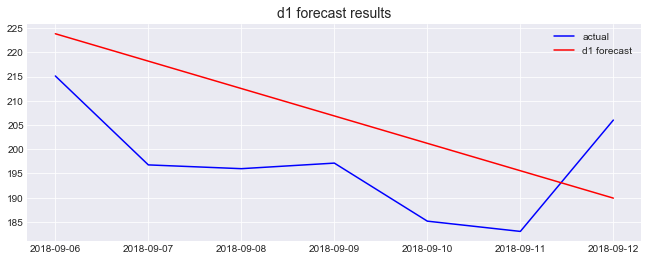

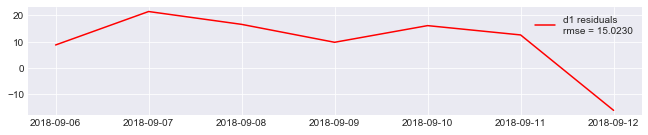

In [38]:
d1 = ARIMA(
    endog=y_train,
    order=(0,1,0)
).fit()

#d1_pred = d1.predict(
#    start=start_date,
#    end=end_date
#)

d1f = d1.forecast(steps=7)
d1f_resid = d1f[0] - y_test
d1f_rmse = np.sqrt((d1f_resid ** 2).mean())

# plot results
plt.figure(figsize=(11,4))
plt.title('d1 forecast results', size=14)

# actual
plt.plot(
    df_05.index.values[-7:],
    y_test,
    label='actual',
    color='blue',
)

# forecasted
plt.plot(
    df_05.index.values[-7:],
    d1f[0],
    label='d1 forecast',
    color='red',
)
plt.legend()
plt.show()

# resid
plt.figure(figsize=(11,2))
plt.plot(
    df_05.index.values[-7:],
    d1f_resid,
    label='d1 residuals\nrmse = {:.4f}'.format(d1f_rmse),
    color='red',
)
plt.legend()
plt.show()

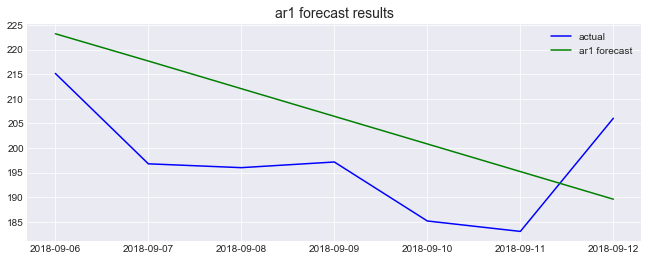

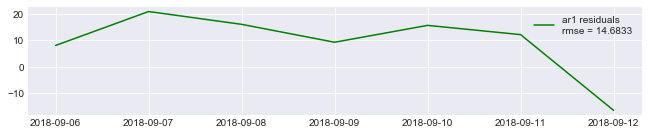

In [37]:
ar1 = ARIMA(
    endog=y_train,
    order=(1,1,0)
).fit()

#ar1_pred = ar1.predict(
#    start=start_date,
#    end=end_date
#)

ar1f = ar1.forecast(steps=7)
ar1f_resid = ar1f[0] - y_test
ar1f_rmse = np.sqrt((ar1f_resid ** 2).mean())

# plot results
plt.figure(figsize=(11,4))
plt.title('ar1 forecast results', size=14)

# actual
plt.plot(
    df_05.index.values[-7:],
    y_test,
    label='actual',
    color='blue',
)

# forecasted
plt.plot(
    df_05.index.values[-7:],
    ar1f[0],
    label='ar1 forecast',
    color='green',
)
plt.legend()
plt.show()

# resids
plt.figure(figsize=(11,2))
plt.plot(
    df_05.index.values[-7:],
    ar1f_resid,
    label='ar1 residuals\nrmse = {:.4f}'.format(ar1f_rmse),
    color='green',
)
plt.legend()
plt.show()

<a id='exog'></a>
## Exogenous Variables
- Ethereum related
    - high
    - low
    - open
    - volume
    - market cap (need to get this working)
- Other Indices (exclude for now need to get current data)
    - VIX
    - DXY
    - EFFR
- Other Cryptocurrencies
    - BTC: Bitcoin
    - XRP: Ripple
    - EOS: EOS.IO
    - LTC: Litecoin
    - XLM: Stellar (need to figure out why its not pulling first values but where I'm working is correct)
    - XMR: Monero

In [25]:
# set df for ts with exogenous variables
dfx = df_orig.copy()
dfx.rename(columns={'eth_close':'eth'}, inplace=True)

# start at the beginning of ethereum
dfx = dfx[dfx.eth.isnull().sum():]
dfx.set_index('date', inplace=True)
dfx.head(3)

,eth_open,eth_high,eth_low,eth,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr
date,,,,,,,,,,,,,,,
2015-08-06,0.6747,3.0,0.6747,3.0,123.93,371.79,277.89,0.008013,NaN,4.10,NaN,0.75,13.77,118.1833,0.14
2015-08-07,3.0000,3.0,0.1500,1.2,2119.43,1438.16,258.60,0.009000,NaN,3.77,NaN,0.75,13.39,118.1833,0.14
2015-08-08,1.2000,1.2,1.2000,1.2,0.00,0.00,263.87,0.008700,NaN,3.87,NaN,0.75,13.39,118.1833,0.14


In [26]:
# split on changepoints returned earlier
dfx_05 = dfx[cpts[3]:]

# check for missingness, applies more for broader date ranges
# than working with here, for example eos came out in jan 2018
print(dfx_05.isnull().sum())

eth_open          0
eth_high          0
eth_low           0
eth               0
eth_volumefrom    0
eth_volumeto      0
btc               0
xrp               0
eos               0
ltc               0
xlm               0
xmr               0
vixcls            0
twexb             0
effr              0
dtype: int64


<a id='exog_modeling'></a>
## Modeling with Exogenous Variables

In [27]:
X = dfx_05.loc[:, ~(dfx_05.columns).isin(['eth'])]
#X = X.astype(float)
y = dfx_05.eth

In [29]:
basex = ARIMA(
    endog=y,
    exog=X,
    order=(0,0,0)
).fit(trend='nc')
#print(basex.summary())
#print('\nbasex rmse = {}'.format(rmse(basex)))

In [30]:
d1x = ARIMA(
    endog=y,
    exog=X,
    order=(0,1,0)
).fit(trend='nc')
#print(d1x.summary())
#print('\nd1x rmse = {}'.format(rmse(d1x)))

In [31]:
ar1x = ARIMA(
    endog=y,
    exog=X,
    order=(1,1,0)
).fit(trend='nc')
#print(ar1x.summary())
#print('\nar1x rmse = {}'.format(rmse(ar1x)))

In [32]:
ma1x = ARIMA(
    endog=y,
    exog=X,
    order=(0,1,1)
).fit(trend='nc')
#print(ma1x.summary())
#print('\nma1x rmse = {}'.format(rmse(ma1x)))

In [33]:
combinedx = ARIMA(
    endog=y,
    exog=X,
    order=(1,1,1)
).fit(trend='nc')
#print(combinedx.summary())
#print('\ncombinedx rmse = {}'.format(rmse(combinedx)))

In [34]:
print('basex\naic: {}\nrmse: {}\n'.format(basex.aic, rmse(basex)))
print('d1x\naic: {}\nrmse: {}\n'.format(d1x.aic, rmse(d1x)))
print('ar1x\naic: {}\nrmse: {}\n'.format(ar1x.aic, rmse(ar1x)))
print('ma1x\naic: {}\nrmse: {}\n'.format(ma1x.aic, rmse(ma1x)))
print('combinedx\naic: {}\nrmse: {}\n'.format(combinedx.aic, rmse(combinedx)))

basex
aic: 244.05686651365198
rmse: 3.7636162666979787

d1x
aic: 224.92335424876444
rmse: 3.1450898023551845

ar1x
aic: 224.41106142637238
rmse: 3.0453637312336643

ma1x
aic: 223.4734885765381
rmse: 3.007860014062423

combinedx
aic: 223.42296095342573
rmse: 2.9276650194700076



<a id='exog_forecasting'></a>
### Forecasting

In [35]:
# forecast last 7 days of series
X_train = X[:-7]
y_train = y[:-7]

X_test = X[-7:]
y_test = y[-7:]

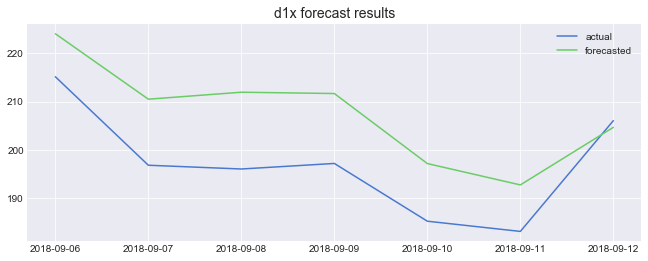

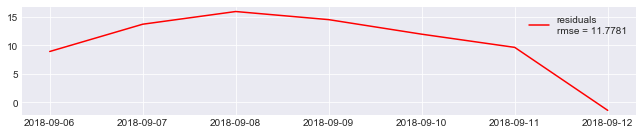

In [44]:
d1x = ARIMA(
    endog=y_train,
    exog=X_train,
    order=(0,1,0)
).fit(trend='nc')

d1xf = d1x.forecast(steps=7, exog=X_test)
d1xf_resid = d1xf[0] - y_test
d1xf_rmse = np.sqrt((d1xf_resid ** 2).mean())

# plot results
plt.figure(figsize=(11,4))
plt.title('d1x forecast results', size=14)

# actual
plt.plot(
    dfx_05.index.values[-7:],
    y_test,
    label='actual',
    #color='blue',
)

# forecsted
plt.plot(
    dfx_05.index.values[-7:],
    d1xf[0],
    label='forecasted',
    #color='g',
)
plt.legend()
plt.show()

# resids
plt.figure(figsize=(11,2))
plt.plot(
    dfx_05.index.values[-7:],
    d1xf_resid,
    label='residuals\nrmse = {:.4f}'.format(d1xf_rmse),
    color='r',
)
plt.legend()
plt.show()

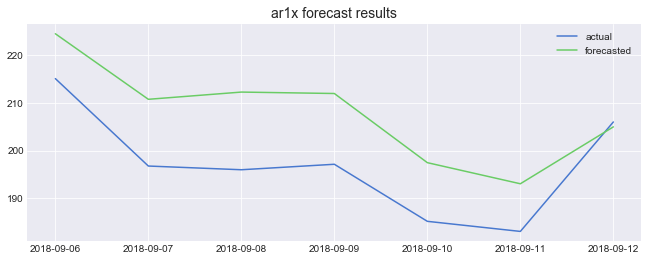

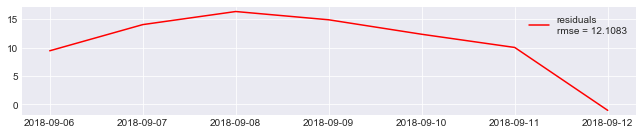

In [46]:
ar1x = ARIMA(
    endog=y_train,
    exog=X_train,
    order=(1,1,0)
).fit(trend='nc')

ar1xf = ar1x.forecast(steps=7, exog=X_test)
ar1xf_resid = ar1xf[0] - y_test
ar1xf_rmse = np.sqrt((ar1xf_resid ** 2).mean())

# plot results
plt.figure(figsize=(11,4))
plt.title('ar1x forecast results', size=14)

# actual
plt.plot(
    dfx_05.index.values[-7:],
    y_test,
    label='actual',
    #color='blue',
)

# forecsted
plt.plot(
    dfx_05.index.values[-7:],
    ar1xf[0],
    label='forecasted',
    #color='g',
)
plt.legend()
plt.show()

# resids
plt.figure(figsize=(11,2))
plt.plot(
    dfx_05.index.values[-7:],
    ar1xf_resid,
    label='residuals\nrmse = {:.4f}'.format(ar1xf_rmse),
    color='r',
)
plt.legend()
plt.show()

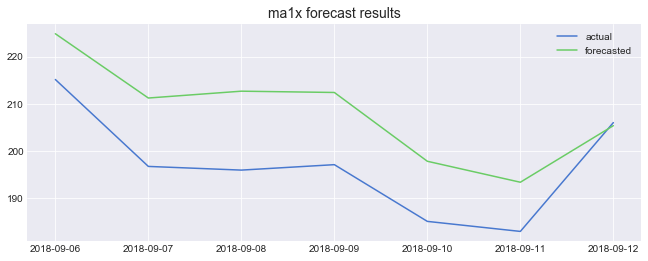

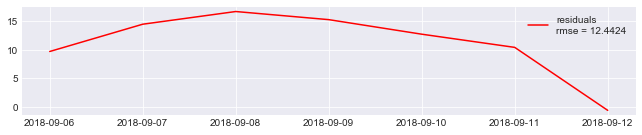

In [48]:
ma1x = ARIMA(
    endog=y_train,
    exog=X_train,
    order=(0,1,1)
).fit(trend='nc')

ma1xf = ma1x.forecast(steps=7, exog=X_test)
ma1xf_resid = ma1xf[0] - y_test
ma1xf_rmse = np.sqrt((ma1xf_resid ** 2).mean())

# plot results
plt.figure(figsize=(11,4))
plt.title('ma1x forecast results', size=14)

# actual
plt.plot(
    dfx_05.index.values[-7:],
    y_test,
    label='actual',
    #color='blue',
)

# forecsted
plt.plot(
    dfx_05.index.values[-7:],
    ma1xf[0],
    label='forecasted',
    #color='g',
)
plt.legend()
plt.show()

# resids
plt.figure(figsize=(11,2))
plt.plot(
    dfx_05.index.values[-7:],
    ma1xf_resid,
    label='residuals\nrmse = {:.4f}'.format(ma1xf_rmse),
    color='r',
)
plt.legend()
plt.show()

In [51]:
#combinedx = ARIMA(
#    endog=y_train,
#    exog=X_train,
#    order=(1,1,1)
#).fit(trend='nc')

#combinedx = combinedx.forecast(steps=7, exog=X_test)
#combinedx_resid = combinedx[0] - y_test
#combinedx_rmse = np.sqrt((combinedx_resid ** 2).mean())

### Granger Causality
[statsmodels_doc](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html)

The null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger-cause the time series in the first column, x1. Granger causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero.

In [138]:
from statsmodels.tsa.stattools import grangercausalitytests

cols = list(dfx_05.loc[:, ~(dfx_05.columns).isin(['eth'])].columns)

for col in cols:
    print('-'*79)
    print('TESTING COLUMN: {}'.format(col))
    print('\ncol 1: eth, col 2: {}'.format(col))
    grangercausalitytests(dfx_05[['eth', '{}'.format(col)]], 1)
    print('\ncol 1: {}, col 2: eth'.format(col))
    grangercausalitytests(dfx_05[['{}'.format(col), 'eth']], 1)

-------------------------------------------------------------------------------
TESTING COLUMN: eth_open

col 1: eth, col 2: eth_open

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1729  , p=0.6801  , df_denom=35, df_num=1
ssr based chi2 test:   chi2=0.1877  , p=0.6648  , df=1
likelihood ratio test: chi2=0.1873  , p=0.6652  , df=1
parameter F test:         F=0.1729  , p=0.6801  , df_denom=35, df_num=1

col 1: eth_open, col 2: eth

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3985.3016, p=0.0000  , df_denom=35, df_num=1
ssr based chi2 test:   chi2=4326.8989, p=0.0000  , df=1
likelihood ratio test: chi2=180.2630, p=0.0000  , df=1
parameter F test:         F=3985.3016, p=0.0000  , df_denom=35, df_num=1
-------------------------------------------------------------------------------
TESTING COLUMN: eth_high

col 1: eth, col 2: eth_high

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3483  , p=0.5589  , df_d